## Imports

In [14]:
# pyqubo stuff
from pyqubo import Array, Constraint, Placeholder, solve_qubo


import math
import matplotlib.pyplot as plt
import numpy as np
import random
import re

## Constants

In [15]:
SQUARE_SIZE = 2
BITS = SQUARE_SIZE * SQUARE_SIZE

In [16]:
# get the vector index given the i, j, k magic square matrix identifiers
def get_index(i, j, k):
    
    # we need to know the length of the magic square matrix horizontally
    row_length = BITS * SQUARE_SIZE
    
    return int((i*row_length) + (j*BITS) + k)

## Magic Square Implementation

In [ ]:
def implement_row(H, variables, penalty):
    """Ensure the all rows sum to the magic constant

    Args:
        variables (Array -> Binary): the binary variables that are being used to encode the results
        penalty (Int): a quantity which scales the impact of the penalty on the objective function
    """
    for i1 in range(SQUARE_SIZE):
        for i2 in range(i1+1, SQUARE_SIZE):

            H_tmp = 0
            
            for j in range(SQUARE_SIZE):
                for k in range(BITS):
                    H_tmp += Constraint(variables[get_index(i1, j, k)], label=f"column_{i2}_{j}_{k}")

            for j in range(SQUARE_SIZE):
                for k in range(BITS):
                    H_tmp -= Constraint(variables[get_index(i2, j, k)], label=f"column_{i1}_{j}_{k}")

            H_tmp **= 2
            H += H_tmp

    H *= penalty
    
    return H

$$S_{\text{col=j}} = \sum_{i=1}^{n}\sum_{k=1}^{s}x_{i,j,k}$$
$$P_{\text{col}} = \sum_{j1>j2}^{n}\left[\sum_{i=1}^{n}\sum_{k=1}^{s}x_{i,j2,k} - \sum_{i=1}^{n}\sum_{k=1}^{s}x_{i,j1,k}\right]^2$$

In [18]:
def implement_column(H, variables, penalty=1):
    """Aim is to ensure all columns sum to the magic constant

    
    Args:
        variables (_type_): _description_
        penalty (_type_): _description_
    """

    for j1 in range(SQUARE_SIZE):
        for j2 in range(j1+1, SQUARE_SIZE):

            H_tmp = 0
            
            for i in range(SQUARE_SIZE):
                for k in range(BITS):
                    H_tmp += Constraint(variables[get_index(i, j2, k)], label=f"column_{i}_{j2}_{k}")

            for i in range(SQUARE_SIZE):
                for k in range(BITS):
                    H_tmp -= Constraint(variables[get_index(i, j1, k)], label=f"column_{i}_{j1}_{k}")

            H_tmp **= 2

            H += H_tmp

    H *= penalty
    
    return H

$$P_{\text{diag}} = $$

In [19]:
def implement_diagonal(variables, penalty):
    """Aim is to ensure the diagonal sums to the magic constant

    Args:
        variables (Array -> Binary): the binary variables that are being used to encode the results
        penalty (Int): a quantity which scales the impact of the penalty on the objective function
    """
    pass

$$P_{\text{unique}} = \sum_{k=1}^{s}\left[(\sum_{i=1}^{n}\sum_{j=1}^{n}x_{i,j,k}) - 1\right]^2$$

In [ ]:
def implement_unique(H, variables, penalty):
    """Aim is to make sure the each number in the magic square is unique

    Args:
        variables (Array -> Binary): the binary variables that are being used to encode the results
        penalty (Int): a quantity which scales the impact of the penalty on the objective function
    """

    for k in range(BITS):
        H += Constraint(penalty * (sum(variables[get_index(i,j,k)] for i in range(SQUARE_SIZE) for j in range(SQUARE_SIZE)) - 1) ** 2, label="unique")

    return H

$$P_{\text{ohe}} = \sum_{i}^{n}\sum_{j}^{n}\left[(\sum_{k}^{s}x_{i,j,k}) - 1\right]^2$$

In [21]:
def implement_ohe(H, variables, penalty):
    """Aim is to ensure that the results produced only have one bit set to 1 for a valid encoding


    Args:
        variables (Array -> Binary): the binary variables that are being used to encode the results
        penalty (Int): a quantity which scales the impact of the penalty on the objective function
    """
    
    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):
            H_tmp = 0
            
            for k in range(BITS):
                H_tmp += variables[get_index(i,j,k)]

            # H += Constraint(penalty * (H_tmp - 1) ** 2, label="one_hot_encoding")
            H += Constraint(penalty * ((H_tmp**2) - (2 * H_tmp) + 1) , label="one_hot_encoding")

    return H

In [22]:
def implement_empty(H, variables, penalty=1):

    def xor(var1, var2):
        return (var1 + var2) - (2 * var1 * var2)

    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):
                H += Constraint(penalty * np.prod([1 - xor(var, 0) for var in list(variables)[get_index(i,j,0):get_index(i,j,BITS)]]), label=f"empty_{i}_{j}")

    return H
                

## Construct QUBO

In [ ]:
array = Array.create('x', SQUARE_SIZE * SQUARE_SIZE * BITS, 'BINARY')

# apply constraints
H = 0
# H += implement_empty(H, array, 10)
H += implement_ohe(H, array, 1)
H += implement_unique(H, array, 1)
H += implement_column(H, array, 1)
H += implement_row(H, array, 1)

NameError: name 'Array' is not defined

## Display Qubo

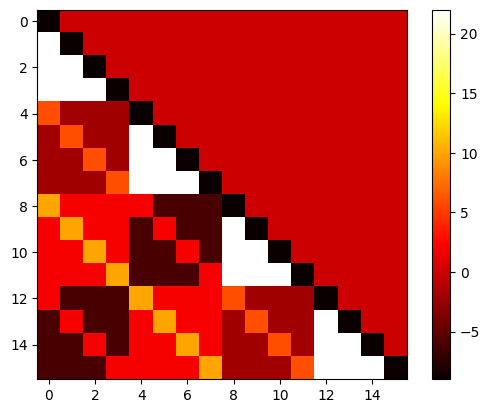

In [24]:
model = H.compile()
qubo, offset = model.to_qubo()

Q = np.zeros((SQUARE_SIZE * SQUARE_SIZE * BITS, SQUARE_SIZE * SQUARE_SIZE * BITS))

for key, value in qubo.items():
    i = int(re.search(r'\[(\d+)\]', key[0]).group(1))
    j = int(re.search(r'\[(\d+)\]', key[1]).group(1))

    Q[i][j] = value



plt.imshow(Q, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()

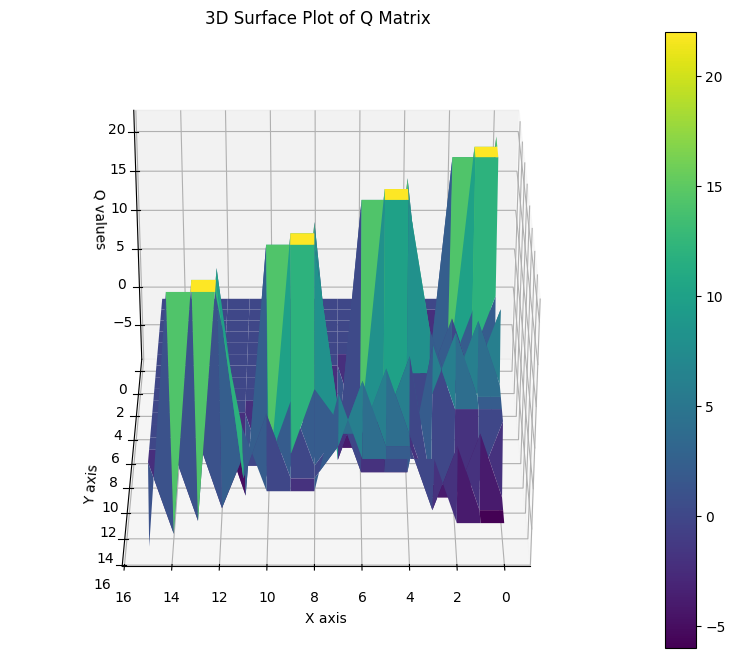

In [25]:
# Create a meshgrid for the indices of the Q matrix
x = np.arange(Q.shape[0])
y = np.arange(Q.shape[1])
x, y = np.meshgrid(x, y)

# Create a figure and a 3D axis
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(x, y, Q, cmap='viridis')

# Add a color bar which maps values to colors
fig.colorbar(surf)
    
# Set labels
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Q values')

# Set title
ax.set_title('3D Surface Plot of Q Matrix')

ax.view_init(elev=30, azim=90)  # Adjust 'elev' as needed for better visibility

plt.show()

## Perform Simulated Annealing

In [26]:
import neal

# compile and convert to binary quadratic model
model = H.compile()
bqm = model.to_bqm()

# simulate
sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads=5000)
decoded_samples = model.decode_sampleset(sampleset)

# decode
solutions = []

for solution in decoded_samples:
    
    # get the sample and energy
    sample = solution.sample
    energy = solution.energy

    # split the sample values into bit sized chunks
    # sample = np.array([list(sample.values())[i:i+BITS] for i in range(0, len(sample), BITS)]).reshape((SQUARE_SIZE, SQUARE_SIZE, BITS))
    sample = np.array([sample[f"x[{i}]"] for i in range(SQUARE_SIZE * SQUARE_SIZE * BITS)]).reshape((SQUARE_SIZE, SQUARE_SIZE, BITS))  

    solutions.append({"sample": sample, "energy": energy})

In [ ]:
# save the solutions
np.save(f"solutions_{SQUARE_SIZE}.npy", {"solutions": solutions, "time": sampleset.info["timing"]})

## Perform Real Annealing

In [ ]:
# save the solutions
np.save(f"solutions_{SQUARE_SIZE}.npy", {"solutions": solutions, "time": sampleset.info["timing"]})

## Analyse

In [27]:
def get_grid(sample):
    grid = np.zeros((SQUARE_SIZE, SQUARE_SIZE))
    
    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):

            # get the item
            item = list(sample[i][j])
            
            if sum(item) == 1:
                index = item.index(1) + 1
                grid[i][j] = index
            else:
                grid[i][j] = -1
    return np.array(grid)


def check_ohe(sample):
    
    count = 0

    # count how many samples are not one hot encoded
    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):
            if sum(sample[i][j]) != 1:
                count += 1

    # return the number of samples that are not one hot encoded
    if count > 0:
        return count

    # return True if all samples are one hot encoded
    return True


def check_unique(sample):
    for k in range(BITS):
        if sum([sample[i][j][k] for i in range(SQUARE_SIZE) for j in range(SQUARE_SIZE)]) != 1:
            return False
    return True


def check_sum_col(sample):

    # get grid and sum cols
    grid = get_grid(sample)
    sums = [int(sum(grid[:,i])) for i in range(SQUARE_SIZE)]

    # test for equality
    if len(set(sums)) == 1:
        return True
    return False

def check_sum_row(sample):
    
    # get grid and sum rows
    grid = get_grid(sample)
    sums = [int(sum(grid[i,:])) for i in range(SQUARE_SIZE)]

    # test for equality
    if len(set(sums)) == 1:
        return True
    return False

    
ohe_incorrect = {}

ohe = 0
unique = 0
sumcol = 0
sumrow = 0

for solution in solutions:
    if check_ohe(solution["sample"]) is True:
        ohe += 1
    else:
        count = check_ohe(solution["sample"])
        if count in ohe_incorrect:
            ohe_incorrect[count] += 1
        else:
            ohe_incorrect.setdefault(count, 1)
            
        continue # avoid checking for unique if the ohe is not correct

    # print(get_grid(solution["sample"]))
    
    if check_unique(solution["sample"]):
        unique += 1

    if check_sum_col(solution["sample"]):
        sumcol += 1

    if check_sum_row(solution["sample"]):
        sumrow += 1

print(f"OHE Correct: {ohe}/{len(solutions)}")
print(f"Unique Correct: {unique}/{len(solutions)}")
print(f"Sum Column Correct: {sumcol}/{len(solutions)}")
print(f"Sum Row Correct: {sumrow}/{len(solutions)}")
print(f"OHE Incorrect: {ohe_incorrect}")


OHE Correct: 5000/5000
Unique Correct: 4808/5000
Sum Column Correct: 1636/5000
Sum Row Correct: 1577/5000
OHE Incorrect: {}


## Show Example

In [28]:

def to_decimal(item):
    if sum(item) == 1:
        return item.index(1) + 1
    else:
        return -1

def get_grid(sample):
    
        
    grid = np.zeros((SQUARE_SIZE, SQUARE_SIZE))
    
    for i in range(SQUARE_SIZE):
        for j in range(SQUARE_SIZE):

            # get the item
            item = list(sample[i][j])

            # convert binary value to decimal
            grid[i][j] = to_decimal(item)
            
    return np.array(grid)

# condense into count
def condense_results(solutions):
    
    condensed = {}
    
    for solution in solutions:
        sample = solution["sample"]
        energy = solution["energy"]

        # extract the values
        key = str(sample.flatten())
        
        if key not in condensed:
            condensed[key] = {"count": 0, "energy": energy}
        
        condensed[key]["count"] += 1
    
    return condensed

condensed = condense_results(solutions)

for key, value in condensed.items():
    print(get_grid(np.array([int(i) for i in key[1:-1].split(" ")]).reshape((SQUARE_SIZE, SQUARE_SIZE, BITS))))
    print(value)
    print("\n\n")

[[3. 2.]
 [1. 4.]]
{'count': 181, 'energy': 0.0}



[[3. 1.]
 [2. 4.]]
{'count': 210, 'energy': 0.0}



[[2. 3.]
 [1. 4.]]
{'count': 200, 'energy': 0.0}



[[4. 2.]
 [1. 3.]]
{'count': 206, 'energy': 0.0}



[[4. 1.]
 [2. 3.]]
{'count': 209, 'energy': 0.0}



[[2. 4.]
 [1. 3.]]
{'count': 211, 'energy': 0.0}



[[4. 3.]
 [1. 2.]]
{'count': 199, 'energy': 0.0}



[[3. 4.]
 [1. 2.]]
{'count': 231, 'energy': 0.0}



[[4. 3.]
 [2. 1.]]
{'count': 202, 'energy': 0.0}



[[3. 4.]
 [2. 1.]]
{'count': 229, 'energy': 0.0}



[[2. 1.]
 [4. 3.]]
{'count': 187, 'energy': 0.0}



[[3. 1.]
 [4. 2.]]
{'count': 200, 'energy': 0.0}



[[3. 2.]
 [4. 1.]]
{'count': 198, 'energy': 0.0}



[[2. 3.]
 [4. 1.]]
{'count': 186, 'energy': 0.0}



[[2. 1.]
 [3. 4.]]
{'count': 190, 'energy': 0.0}



[[4. 1.]
 [3. 2.]]
{'count': 200, 'energy': 0.0}



[[4. 2.]
 [3. 1.]]
{'count': 197, 'energy': 0.0}



[[2. 4.]
 [3. 1.]]
{'count': 200, 'energy': 0.0}



[[1. 3.]
 [2. 4.]]
{'count': 191, 'energy': 0.0}



[[1. 4.]
 [2